In [9]:
# Load data
import pickle

num_leapfrog_steps = 1000
file = 'BNN-B-' + str(num_leapfrog_steps) + '.pkl'

#with open('../../Results/A vs N - 1000+/' + file, 'rb') as f:
with open(file, 'rb') as f:
    samples = pickle.load(f)
    momentum_norm_total = pickle.load(f)
    alphas = pickle.load(f)
    proposed_H_store = pickle.load(f)
    current_H = pickle.load(f)
    grad_list_total = pickle.load(f)
    negative_log_posterior_list_total = pickle.load(f)
    acceptance_list = pickle.load(f)
    MAP_weights = pickle.load(f)
    MAP_biases = pickle.load(f)
    momentum_keep = pickle.load(f)
    potential_keep = pickle.load(f)

num_samples = len(acceptance_list)

import numpy as np
import matplotlib.pyplot as plt

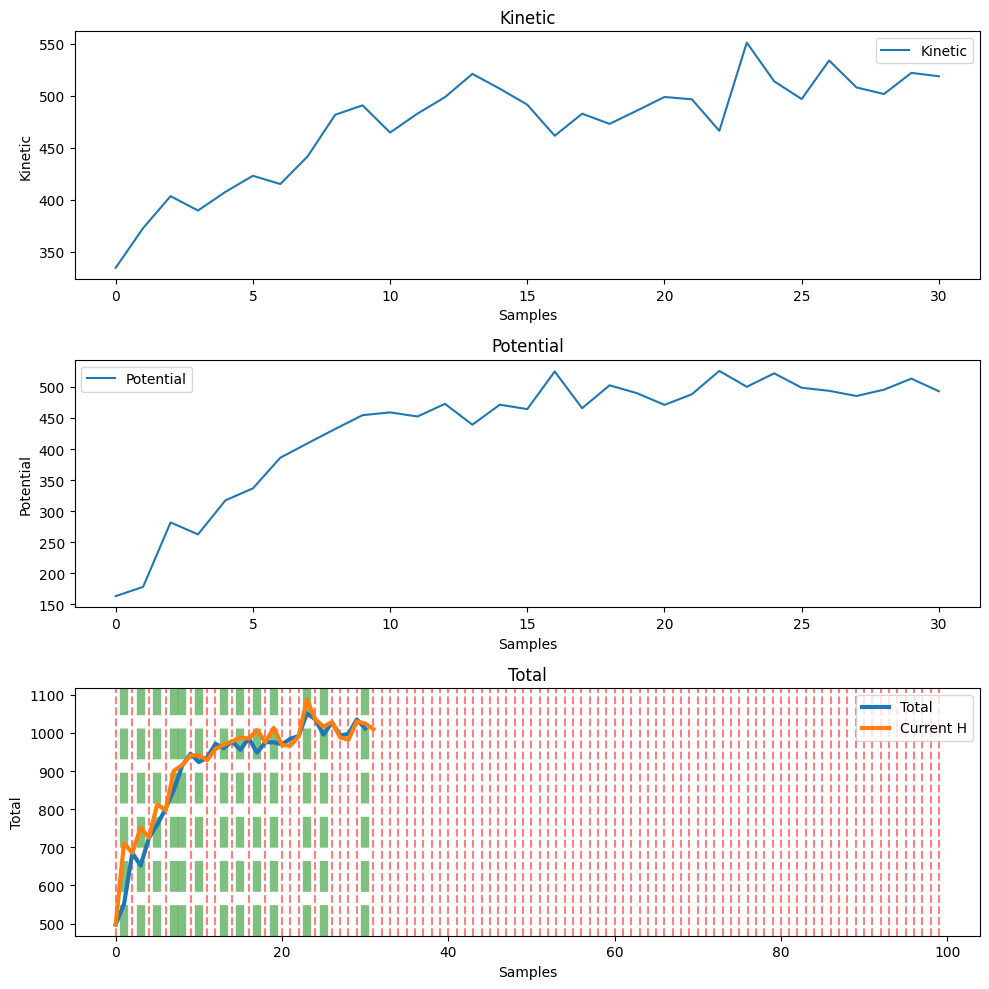

In [10]:
# plot momentum_keep and potential_keep in subplots and another subplot for summation of the two
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.plot(momentum_keep, label='Kinetic')
plt.xlabel('Samples')
plt.ylabel('Kinetic')
plt.title('Kinetic')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(potential_keep, label='Potential')
plt.xlabel('Samples')
plt.ylabel('Potential')
plt.title('Potential')
plt.legend()

plt.subplot(3, 1, 3)
for i in range(num_samples):
    if acceptance_list[i] == 1:
        plt.axvline(x=i, color='g', linestyle='--', linewidth=6, alpha=0.5)
    else:
        plt.axvline(x=i, color='r', linestyle='--', alpha=0.5)
plt.plot(np.add(momentum_keep, potential_keep), label='Total', linewidth=3)
plt.plot(current_H, label='Current H', linewidth=3)
plt.xlabel('Samples')
plt.ylabel('Total')
plt.title('Total')
#plt.xlim(0, 45)
plt.legend()

plt.tight_layout()
plt.savefig('BPINN_leapfrog_' + str(num_leapfrog_steps) +'_energies.png')
plt.show()

x shape: (1000,)
t shape: (1000,)
u0: (1000,)
U_1D shape: (1000,)
X shape: (1000, 1000)
T shape: (1000, 1000)
U shape: (1000, 1000)


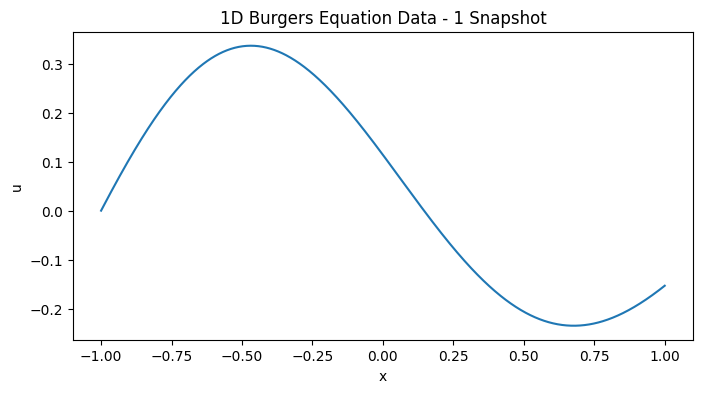

In [11]:
# Define the parameters for the Burger's equation
nu = 0.2 / np.pi  # Viscosity
N = 1000  # Number of data points

# Generate the spatial domain
x = np.linspace(-1, 1, N)
t = np.linspace(0, 1, N)
X, T = np.meshgrid(x, t)

# Initial condition
u0 = -np.sin(np.pi * x)

# Generate the dataset
def burgers_exact(x, t, nu):
    return -2 * nu * np.pi * np.sin(np.pi * (x - 4 * nu * t)) * np.exp(-np.pi**2 * nu * t)
# Exact solution: u(x, t) = -2 * nu * pi * sin(pi * (x - 4 * nu * t)) * exp(-pi^2 * nu * t)
# If t = 0, u(x, 0) = -2 * nu * pi * sin(pi * x) = -2 * 0.01/pi * pi * sin(pi * x) = -0.02 * sin(pi * x)
# If t = 1, u(x, 1) = -2 * nu * pi * sin(pi * (x - 4 * nu)) = -2 * 0.01/pi * pi * sin(pi * (x - 4 * 0.01/pi)) = -0.02 * sin(pi * (x - 4 * 0.01/pi))

U_1D = burgers_exact(x, t, nu)
U = burgers_exact(X, T, nu)

# Plot sizes of all the data
print("x shape:", x.shape)
print("t shape:", t.shape)
print("u0:", u0.shape)
print("U_1D shape:", U_1D.shape)
print("X shape:", X.shape)
print("T shape:", T.shape)
print("U shape:", U.shape)

plt.figure(figsize=(8, 4))
plt.plot(x, U_1D)
plt.xlabel('x')
plt.ylabel('u')
plt.title('1D Burgers Equation Data - 1 Snapshot')
plt.show()

Y = burgers_exact(x, t, nu)
X = x
Y = Y.reshape(-1, 1).astype(np.float32)
X = X.reshape(-1, 1).astype(np.float32)

In [12]:
import tensorflow as tf

# Define the neural network architecture
class BayesianNeuralNetwork:
    def __init__(self, input_dim, hidden1, hidden2, output_dim, dropout_rate=0.):
        # Initialize weights and biases as TensorFlow variables
        initializer = tf.initializers.GlorotUniform()

        # Define trainable parameters (weights and biases)
        self.weights = [
            tf.Variable(initializer([input_dim, hidden1]), dtype=tf.float32),
            tf.Variable(initializer([hidden1, hidden2]), dtype=tf.float32),
            tf.Variable(initializer([hidden2, output_dim]), dtype=tf.float32)
        ]
        
        self.biases = [
            tf.Variable(tf.zeros([hidden1]), dtype=tf.float32),
            tf.Variable(tf.zeros([hidden2]), dtype=tf.float32),
            tf.Variable(tf.zeros([output_dim]), dtype=tf.float32)
        ]

        self.dropout_rate = dropout_rate

    def forward(self, X, training=True):
        # Layer 1 with tanh activation
        hidden1 = tf.matmul(X, self.weights[0]) + self.biases[0]
        hidden1_activation = tf.nn.tanh(hidden1)
        if training:
            hidden1_activation = tf.nn.dropout(hidden1_activation, rate=self.dropout_rate)
        
        # Layer 2 with tanh activation
        hidden2 = tf.matmul(hidden1_activation, self.weights[1]) + self.biases[1]
        hidden2_activation = tf.nn.tanh(hidden2)
        if training:
            hidden2_activation = tf.nn.dropout(hidden2_activation, rate=self.dropout_rate)
        
        # Output layer (linear activation)
        output = tf.matmul(hidden2_activation, self.weights[2]) + self.biases[2]
        return output
    
# Initialize the Bayesian neural network
input_dim = 1
hidden1 = 256
hidden2 = 256
output_dim = 1

model = BayesianNeuralNetwork(input_dim, hidden1, hidden2, output_dim)

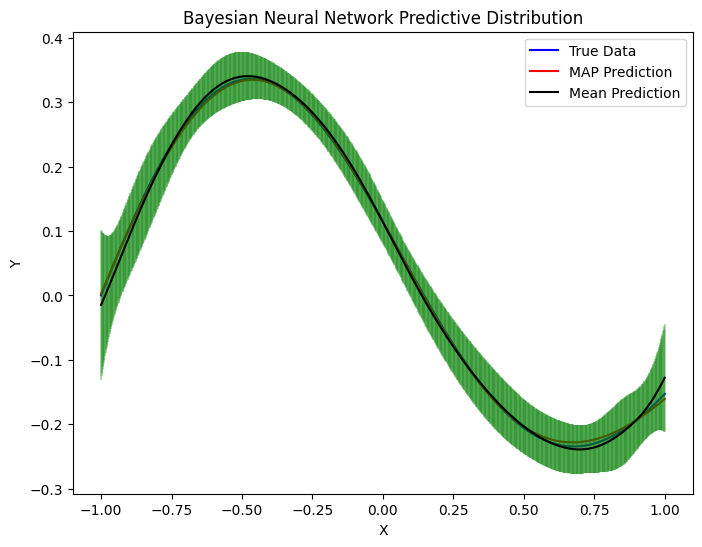

In [13]:
X_tf = tf.constant(X)
Y_tf = tf.constant(Y)

# Predictive distribution;
plt.figure(figsize=(8, 6))
plt.plot(X, Y, alpha=1, color='blue', label='True Data')
model.weights = MAP_weights
model.biases = MAP_biases
plt.plot(X, model.forward(X_tf).numpy(), color='red', label='MAP Prediction')
Y_preds_sampled = []
for sample in samples:
    model.weights = sample[:3]
    model.biases = sample[3:]
    Y_pred = model.forward(X_tf)
    Y_preds_sampled.append(Y_pred)
Y_preds_sampled = np.array(Y_preds_sampled)
Y_mean = np.mean(Y_preds_sampled, axis=0)
Y_std = np.std(Y_preds_sampled, axis=0)
# Plot the confidence interval
for i in range(len(X)):
    plt.plot([X[i], X[i]], [Y_mean[i] - 2 * Y_std[i], Y_mean[i] + 2 * Y_std[i]], color='green', alpha=0.3)
plt.plot(X, Y_mean, color='black', label='Mean Prediction')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Bayesian Neural Network Predictive Distribution")
plt.legend()
plt.show()

In [14]:
import pandas as pd

# Convert tensor
x = tf.convert_to_tensor(X)
y = tf.convert_to_tensor(Y)

def compute_residual(model, x, y, nu):
    dx = x[1] - x[0]  # Assuming uniform grid
    xE, xW = x + dx, x - dx  # u(x-dx) = uW, u(x) = u, u(x+dx) = uE
    uE, uW = model.forward(xE), model.forward(xW)

    with tf.GradientTape(persistent=True) as tape2_xE, tf.GradientTape(persistent=True) as tape2_xW, tf.GradientTape(persistent=True) as tape2_x:
        tape2_xE.watch(xE)
        tape2_xW.watch(xW)
        tape2_x.watch(x)
        with tf.GradientTape(persistent=True) as tape_xE, tf.GradientTape(persistent=True) as tape_xW, tf.GradientTape(persistent=True) as tape_x:
            tape_xE.watch(xE)
            tape_xW.watch(xW)
            tape_x.watch(x)
            uE, uW, u = model.forward(xE), model.forward(xW), model.forward(x)
        uE_x, uW_x, u_x = tape_xE.gradient(uE, xE), tape_xW.gradient(uW, xW), tape_x.gradient(u, x)
    uE_xx, uW_xx, u_xx = tape2_xE.gradient(uE_x, xE), tape2_xW.gradient(uW_x, xW), tape2_x.gradient(u_x, x)

    uEm_uw2 = u + u_x * dx / 2
    uEp_uw2 = uE - uE_x * dx / 2
    uWm_uw2 = uW + uW_x * dx / 2
    uWp_uw2 = u - u_x * dx / 2
    uE_uw2 = tf.where(tf.greater_equal(u_x, 0.0), uEm_uw2, uEp_uw2)
    uW_uw2 = tf.where(tf.greater_equal(u_x, 0.0), uWm_uw2, uWp_uw2)
    u_uw2 = (uE_uw2 + uW_uw2) / 2
    u_x_uw2 = (uE_uw2 - uW_uw2) / dx

    uEm_x_uw2 = u_x + u_xx * dx / 2
    uEp_x_uw2 = uE_x - uE_xx * dx / 2
    uWm_x_uw2 = uW_x + uW_xx * dx / 2
    uWp_x_uw2 = u_x - u_xx * dx / 2
    uE_x_uw2 = tf.where(tf.greater_equal(u_x, 0.0), uEm_x_uw2, uEp_x_uw2)
    uW_x_uw2 = tf.where(tf.greater_equal(u_x, 0.0), uWm_x_uw2, uWp_x_uw2)
    u_xx_uw2 = (uE_x_uw2 - uW_x_uw2) / dx

    residual = u_uw2 * u_x_uw2 - nu * u_xx_uw2

    # Save first and second terms of residual into a dataframe
    first_term = u_uw2 * u_x_uw2
    second_term = nu * u_xx_uw2

    residual_others = pd.DataFrame({'x': x.numpy().flatten(), 'u': u.numpy().flatten(), 'u_x': u_x.numpy().flatten(), 'u_xx': u_xx.numpy().flatten()})
    residual_df = pd.DataFrame({'x': x.numpy().flatten(), 'residual': residual.numpy().flatten(), 'first_term': first_term.numpy().flatten(), 'second_term': second_term.numpy().flatten()})
    
    return residual_df, residual_others

# Example usage
residual_df, residual_others = compute_residual(model, x, y, nu)


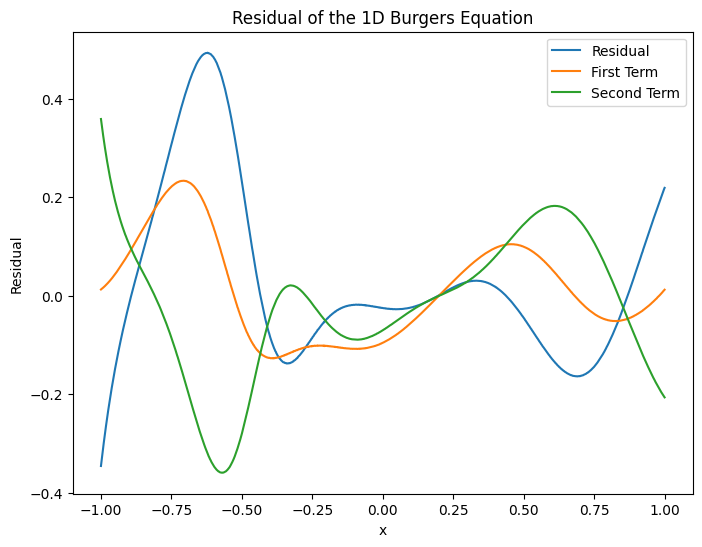

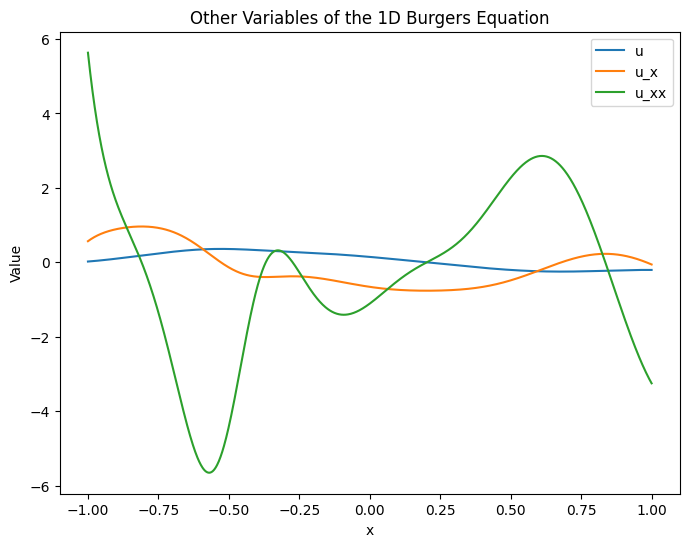

In [15]:
# Plot the residual
plt.figure(figsize=(8, 6))
plt.plot(residual_df['x'], residual_df['residual'], label='Residual')
plt.plot(residual_df['x'], residual_df['first_term'], label='First Term')
plt.plot(residual_df['x'], residual_df['second_term'], label='Second Term')
plt.xlabel('x')
plt.ylabel('Residual')
plt.title('Residual of the 1D Burgers Equation')
plt.legend()
plt.show()

# Plot the residual_others
plt.figure(figsize=(8, 6))
plt.plot(residual_others['x'], residual_others['u'], label='u')
plt.plot(residual_others['x'], residual_others['u_x'], label='u_x')
plt.plot(residual_others['x'], residual_others['u_xx'], label='u_xx')
plt.xlabel('x')
plt.ylabel('Value')
plt.title('Other Variables of the 1D Burgers Equation')
plt.legend()
plt.show()

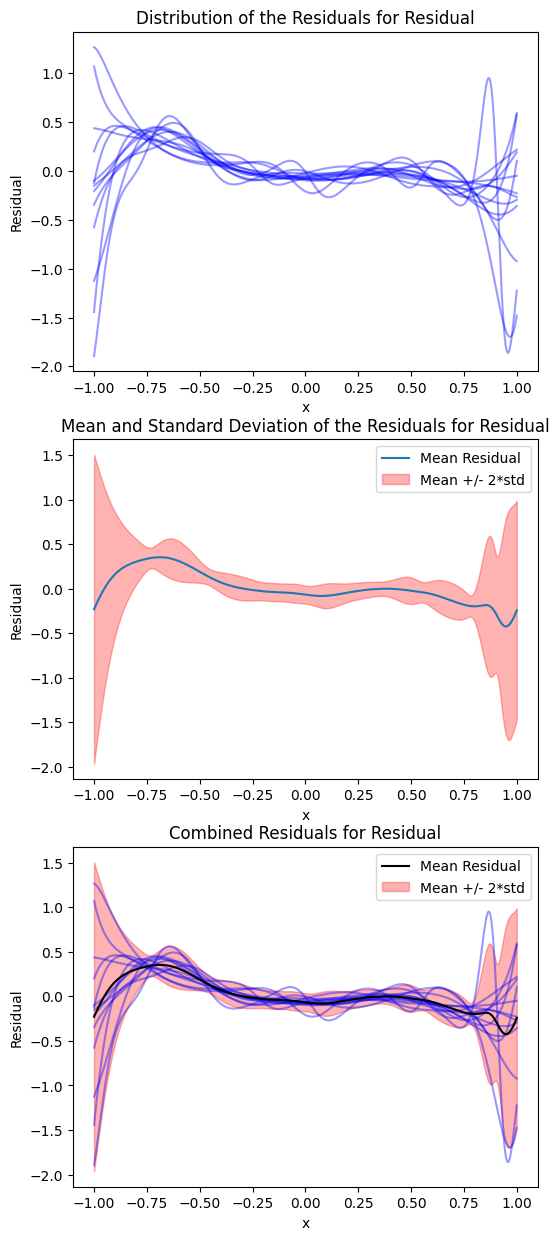

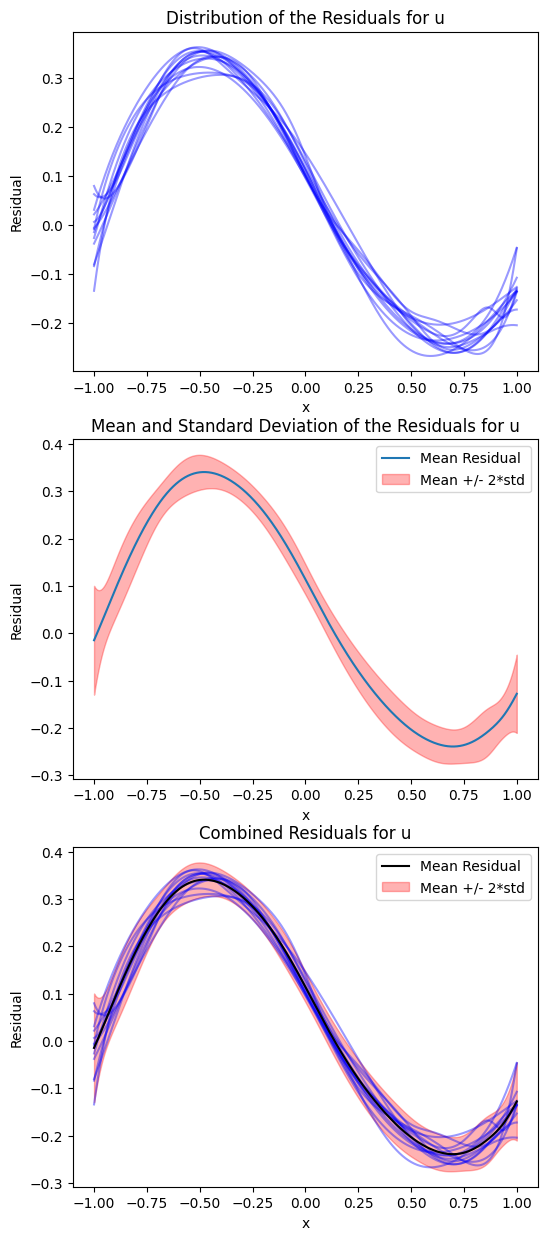

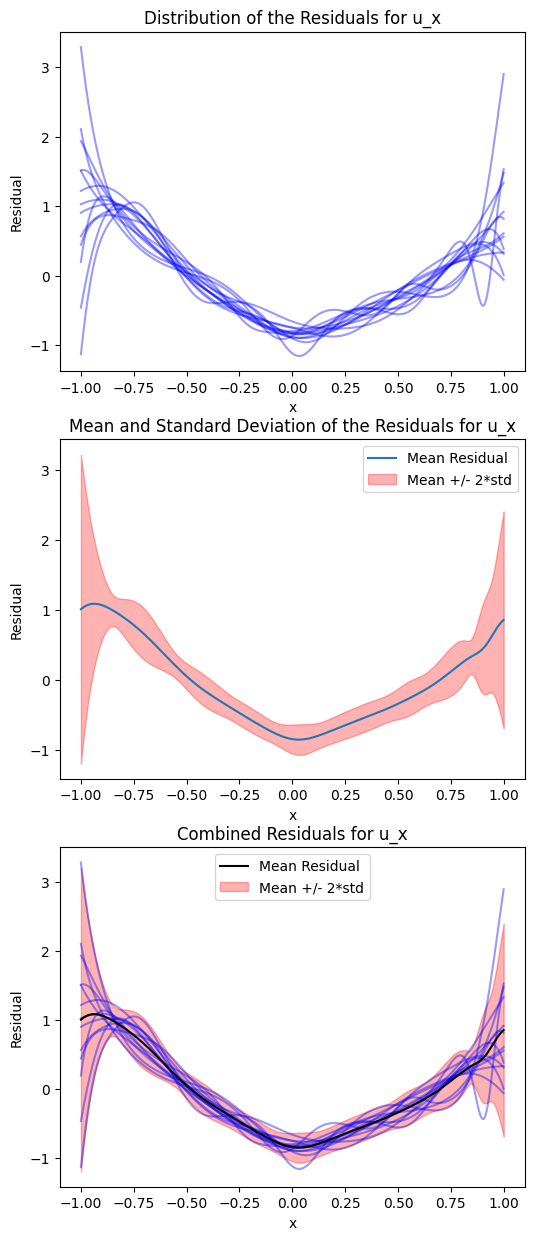

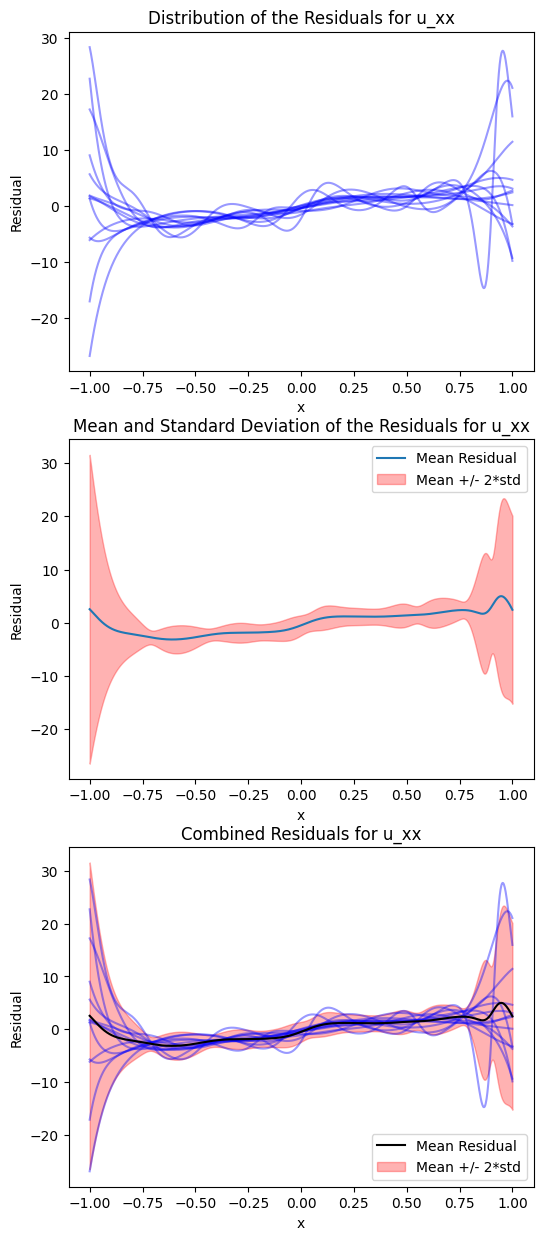

In [16]:
# Use the distributed prediction to compute the residual, using the function compute all residuals
residuals_list = []
residuals_other_list = []
for i in range(Y_preds_sampled.shape[0]):
    model.weights = samples[i][:3]
    model.biases = samples[i][3:]
    residual_df, residual_others = compute_residual(model, x, y, nu)
    residuals_list.append(residual_df['residual'])
    residuals_other_list.append(residual_others)

residuals = pd.concat(residuals_list, axis=1)
residuals['mean_residual'] = residuals.mean(axis=1)
residuals['std_residual'] = residuals.std(axis=1)
residuals_u = pd.concat([residual['u'] for residual in residuals_other_list], axis=1)
residuals_u['mean_residual'] = residuals_u.mean(axis=1)
residuals_u['std_residual'] = residuals_u.std(axis=1)
residuals_u_x = pd.concat([residual['u_x'] for residual in residuals_other_list], axis=1)
residuals_u_x['mean_residual'] = residuals_u_x.mean(axis=1)
residuals_u_x['std_residual'] = residuals_u_x.std(axis=1)
residuals_u_xx = pd.concat([residual['u_xx'] for residual in residuals_other_list], axis=1)
residuals_u_xx['mean_residual'] = residuals_u_xx.mean(axis=1)
residuals_u_xx['std_residual'] = residuals_u_xx.std(axis=1)

# Create function to plot the residuals for residual distribution, mean and standard deviation, and combined
def plot_residuals(residuals, residual_df, title):
    # Plot the residuals for u, u_x, u_xx
    plt.figure(figsize=(6, 15)) # 33.867 cm / 4 = 8.46675 cm. 11.14 cm / 8.46675 cm = 1.315. 8.46675 / 1.315 = 6.44 cm

    # Plot the residual distribution for u
    plt.subplot(3, 1, 1)
    for i in range(Y_preds_sampled.shape[0]):
        plt.plot(residual_df['x'], residuals.iloc[:,i], color='blue', alpha=0.4)
    plt.xlabel('x')
    plt.ylabel('Residual')
    plt.title('Distribution of the Residuals for ' + title)

    # Plot the mean and standard deviation of the residuals for u
    plt.subplot(3, 1, 2)
    plt.plot(residual_df['x'], residuals['mean_residual'], label='Mean Residual')
    plt.fill_between(residual_df['x'], residuals['mean_residual'] - 2 * residuals['std_residual'], residuals['mean_residual'] + 2 * residuals['std_residual'], color='red', alpha=0.3, label='Mean +/- 2*std')
    plt.xlabel('x')
    plt.ylabel('Residual')
    plt.title('Mean and Standard Deviation of the Residuals for ' + title)
    plt.legend()
    #plt.text(0.3, 0.9, f"Mean: {residuals['mean_residual'].mean():.4f}\nStd: {residuals['std_residual'].mean():.4f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5))

    # Combined plot for u
    plt.subplot(3, 1, 3)
    for i in range(Y_preds_sampled.shape[0]):
        plt.plot(residual_df['x'], residuals.iloc[:,i], color='blue', alpha=0.4)
    plt.plot(residual_df['x'], residuals['mean_residual'], label='Mean Residual', color='black')
    plt.fill_between(residual_df['x'], residuals['mean_residual'] - 2 * residuals['std_residual'], residuals['mean_residual'] + 2 * residuals['std_residual'], color='red', alpha=0.3, label='Mean +/- 2*std')
    plt.xlabel('x')
    plt.ylabel('Residual')
    plt.title('Combined Residuals for ' + title)
    plt.legend()

# Use the function to plot for all 4 residuals
# Plot the total residual
plot_residuals(residuals, residual_df, 'Residual')
# Plot the residual for u
plot_residuals(residuals_u, residual_df, 'u')
# Plot the residual for u_x
plot_residuals(residuals_u_x, residual_df, 'u_x')
# Plot the residual for u_xx
plot_residuals(residuals_u_xx, residual_df, 'u_xx')